## Homework

The goal of this homework is to create a regression model for predicting
the Laptops prices (column `'Final Price'`).

### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Seaborn version: {sns.__version__}")

NumPy version: 1.26.4
Pandas version: 2.2.2
Seaborn version: 0.13.2


### Getting the data 

For this homework, I used the Laptops Price dataset. Downloaded from:
https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

In [2]:
URL = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv"
df = pd.read_csv(URL)
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


## Preparing the dataset

First, we’ll normalize the names of the columns:

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

Next, use only the following columns:

-   `'ram'`,
-   `'storage'`,
-   `'screen'`,
-   `'final_price'`

In [4]:
df = df[['ram','storage','screen','final_price']]
df.columns

Index(['ram', 'storage', 'screen', 'final_price'], dtype='object')

### EDA

-   Look at the `final_price` variable. Does it have a long tail?

<Axes: xlabel='final_price', ylabel='Count'>

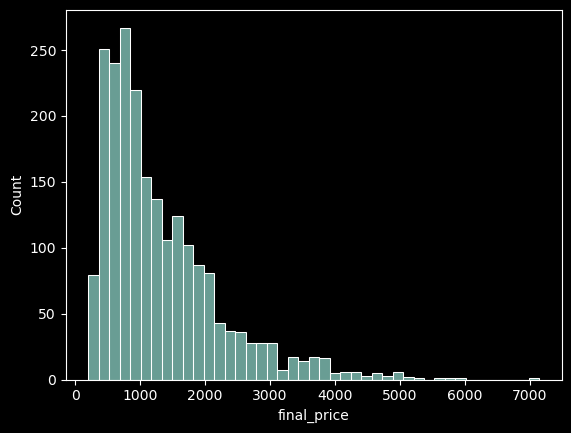

In [5]:
sns.histplot(df.final_price)

<Axes: xlabel='final_price', ylabel='Count'>

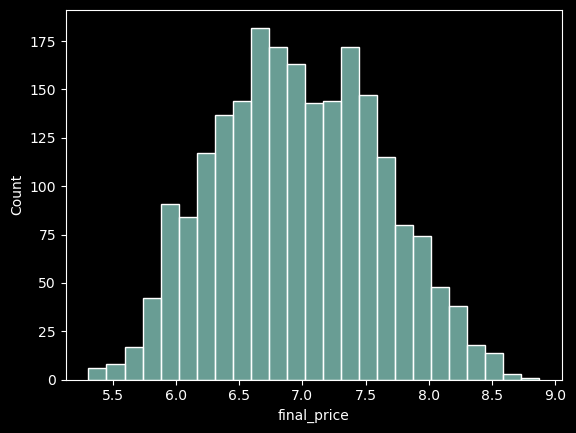

In [6]:
final_price_logs = np.log1p(df.final_price)
sns.histplot(final_price_logs)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ram          2160 non-null   int64  
 1   storage      2160 non-null   int64  
 2   screen       2156 non-null   float64
 3   final_price  2160 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 67.6 KB


In [8]:
df.describe()

,ram,storage,screen,final_price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


In [9]:
df.isna().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [10]:
df[df.duplicated(keep=False)].sort_values(by=['final_price'])

,ram,storage,screen,final_price
813,8,256,14.0,239.00
26,8,256,14.0,239.00
1,8,256,15.6,299.00
1933,8,256,15.6,299.00
540,4,64,14.0,329.00
...,...,...,...,...
100,16,1000,15.6,3299.99
819,32,1000,15.6,3499.00
423,32,1000,15.6,3499.00
716,32,1000,16.0,3699.01


### Question 1

There’s one column with missing values. What is it?

In [11]:
missing_values_count = df.isna().sum()
column_with_missing_values = missing_values_count[missing_values_count > 0].index[0]
print(f"Column with missing values: {column_with_missing_values}")

Column with missing values: screen


### Question 2

What’s the median (50% percentile) for variable `'ram'`?

-   8
-   16
-   24
-   32

In [12]:
ram_median = df.ram.median()
print(f"The median (50% percentile) for variable ram is: {ram_median}")

The median (50% percentile) for variable ram is: 16.0


### Prepare and split the dataset

-   Shuffle the dataset (the filtered one you created above), use seed
    `42`.
-   Split your data in train/val/test sets, with 60%/20%/20%
    distribution.

In [13]:
def split_data(df, test_size=0.2, val_size=0.2, random_state=42):
    n = len(df)
    n_val = int(n * val_size)
    n_test = int(n * test_size)
    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.seed(random_state)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
    df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
    df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

    df_train = df_train.drop('final_price', axis=1)
    df_val = df_val.drop('final_price', axis=1)
    df_test = df_test.drop('final_price', axis=1)

    return df_train, df_val, df_test, y_train, y_val, y_test

In [14]:
df_train, df_val, df_test, y_train, y_val, y_test = split_data(df)

In [15]:
len(df_train), len(df_val), len(df_test)

(1296, 432, 432)

In [16]:
len(y_train), len(y_val), len(y_test)

(1296, 432, 432)

### Question 3

-   We need to deal with missing values for the column from Q1.
-   We have two options: fill it with 0 or with the mean of this
    variable.
-   We will try both options. For each, train a linear regression model without
    regularization using the code from the lessons.


In [17]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [18]:
def prepare_X(df, option = 0.0):
    df = df.fillna(option)
    X = df.values
    return X

In [19]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()

    # Round the RMSE scores to 2 decimal digits
    rmse = round(np.sqrt(mse), 2)
    return rmse

In [20]:
# Fill NAs with 0
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

# Train a linear regression model without regularization
w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_val.dot(w)

# Use the validation dataset to evaluate the models and compare the RMSE of each option.
score_with_0 = rmse(y_val, y_pred)
print(f"Score with 0: {score_with_0}")

Score with 0: 597.36


-   For computing the mean, we use the training only!

In [21]:
screen_mean = df_train.screen.mean()
screen_mean

15.163534416086618

In [22]:
# Train a linear regression model without regularization
w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_val.dot(w)

# Fill NAs with the mean
X_train = prepare_X(df_train, screen_mean)
X_val = prepare_X(df_val, screen_mean)

# Use the validation dataset to evaluate the models and compare the RMSE of each option.
score_with_median = rmse(y_val, y_pred)
print(f"Score with median: {score_with_median}")

Score with median: 597.36


<Axes: ylabel='Count'>

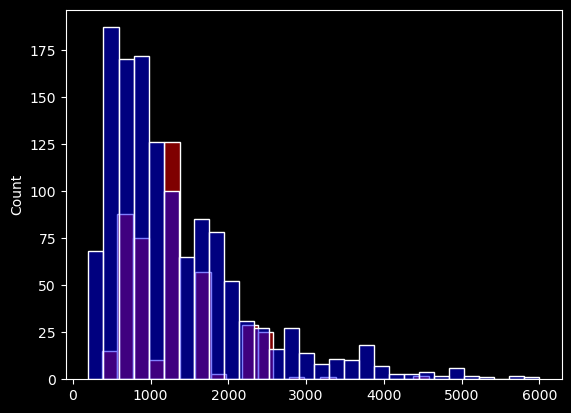

In [23]:
sns.histplot(y_pred, color='red', alpha=0.5)
sns.histplot(y_train, color='blue', alpha=0.5)

-   Which option gives better RMSE?


In [24]:
print(f"The option with better RMSE is fill 'Nas' with 0: {score_with_0}")

The option with better RMSE is fill 'Nas' with 0: 597.36


### Question 4

-   Now let’s train a regularized linear regression.

In [25]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

-   Try different values of `r` from this list:
    `[0, 0.01, 0.1, 1, 5, 10, 100]`.

In [26]:
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]


In [27]:
scores = {}

for r in r_values:
    # For this question, fill the NAs with 0.
    X_train = prepare_X(df_train)
    X_val = prepare_X(df_val)
    
    ## Train a model with regularization.
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)   
    y_pred = w0 + X_val.dot(w)

    # Use RMSE to evaluate the model on the validation dataset.
    score = rmse(y_val, y_pred)
    scores.update({r:score})
    
    print(r, w0, score)

0 676.8954853010354 597.36
0.01 676.273681721199 597.36
0.1 670.7284836319117 597.35
1 619.903083411312 597.21
5 463.7771697145259 597.01
10 352.7971336770357 597.06
100 66.92071440183727 597.9


-   Which `r` gives the best RMSE?

In [28]:
best_score = min(scores, key=scores.get)
print(f"The value of `r` with the best RMSE is: {best_score}")


The value of `r` with the best RMSE is: 5


### Question 5

-   We used seed 42 for splitting the data. Let’s find out how selecting
    the seed influences our score.

-   Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.

In [29]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

-   For each seed, do the train/validation/test split with 60%/20%/20%
    distribution.

In [30]:
scores = []

for seed in seed_values:
    df_train, df_val, df_test, y_train, y_val, y_test = split_data(df, random_state=seed)
    
    # Fill the missing values with 0
    X_train = prepare_X(df_train)
    X_val = prepare_X(df_val)

    # Train a model without regularization.
    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_val.dot(w)

    # Evaluate the model on the validation dataset and collect the RMSE scores.
    score = rmse(y_val, y_pred)
    scores.append(score)
    
    print(seed, w0, score)


0 547.5696230190905 565.45
1 594.4197428005896 636.8
2 649.4685454773346 588.96
3 571.9459040117479 597.81
4 629.3882030650149 571.96
5 580.7647373333743 573.24
6 783.7683689914218 647.34
7 376.4358600628415 550.44
8 572.8852361202732 587.33
9 663.3792792613488 576.1


-   What’s the standard deviation of all the scores?

In [31]:
std_scores = round(np.std(scores), 3)
print(f"The standard deviation of all the scores is: {std_scores}")


The standard deviation of all the scores is: 29.176


> Note: Standard deviation shows how different the values are. If it’s
> low, then all values are approximately the same. If it’s high, the
> values are different. If standard deviation of scores is low, then our
> model is *stable*.

### Question 6

-   Split the dataset like previously, use seed 9.

In [32]:
df_train, df_val, df_test, y_train, y_val, y_test = split_data(df, random_state=9)


-   Combine train and validation datasets.

In [33]:
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = np.concatenate([y_train, y_val])


-   Fill the missing values with 0.

In [34]:
X_full_train = prepare_X(df_full_train)
X_test = prepare_X(df_test)


- Train a model with `r=0.001`.

In [35]:
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)
y_pred = w0 + X_test.dot(w)


-   What’s the RMSE on the test dataset?

In [36]:
score = round(rmse(y_test, y_pred), 2)
print(f"The RMSE on the test dataset is: {score}")


The RMSE on the test dataset is: 608.61


## Reference

-   Original homework: 
    https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2024/02-regression/homework.md